# Environment settings

This code was running in a local enviroment, taking advantage of the local machine's GPU.

In [ ]:
import os
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

# Set GPU memory growth
# Allows to only as much GPU memory as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

balanced_data_dir = os.path.join('Dataset/splitted_data_balanced_new')

# Setting dataset directories
training_dir = os.path.join(balanced_data_dir + '/train')
validation_dir = os.path.join(balanced_data_dir + '/val')

# Data Augmentation

In [ ]:
apply_data_augmentation = True

if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        height_shift_range=25,
                                        width_shift_range=25,
                                        #zoom_range=0.3,
                                        #brightness_range=[0.2,1.8],
                                        #channel_shift_range = 150,
                                        #shear_range = 0.7,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1./255)

else:
    train_data_gen = ImageDataGenerator(rescale=1/255)

# Create validation ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
apply_preprocess_input = False

from tensorflow.keras.applications.vgg16 import preprocess_input
#from tensorflow.keras.applications.resnet_v2 import preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications.vgg19 import preprocess_input
#from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
#from tensorflow.keras.applications.convnext import preprocess_input


if apply_preprocess_input:
    train_data_gen = ImageDataGenerator(rescale = 255,
                                        preprocessing_function = preprocess_input)
    
    valid_data_gen = ImageDataGenerator(rescale= 255,
                                        preprocessing_function = preprocess_input)

# Data

Found 3896 images belonging to 8 classes.
Training Set


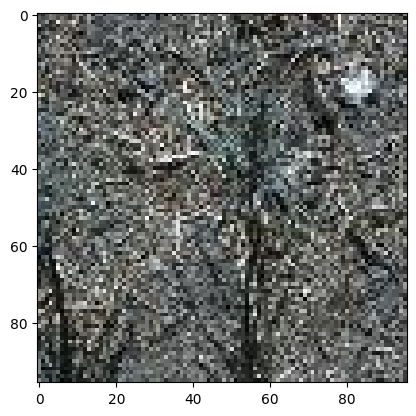

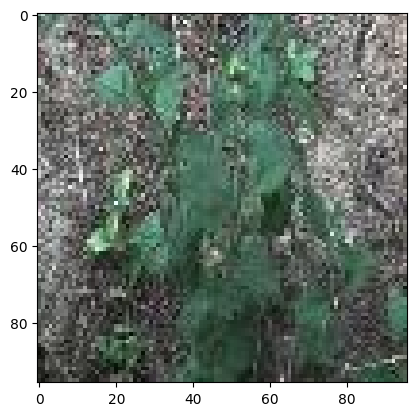

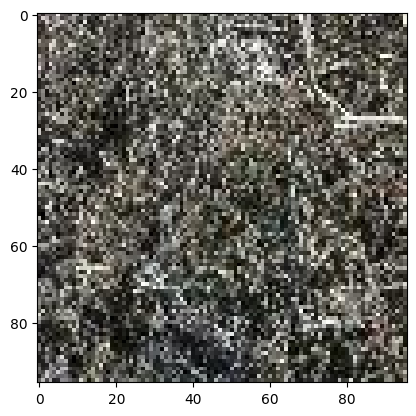

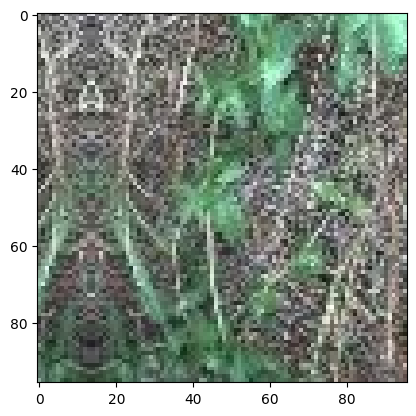

Found 400 images belonging to 8 classes.
Validation Set


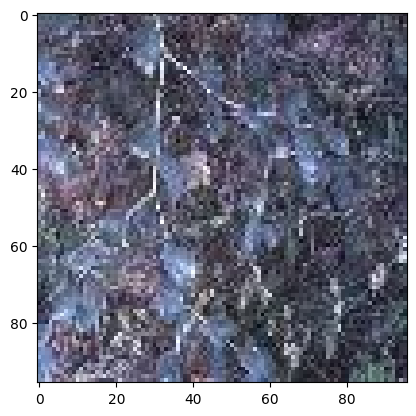

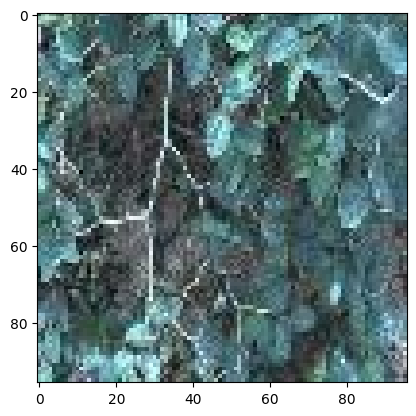

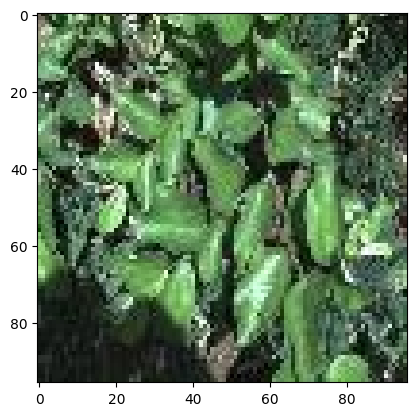

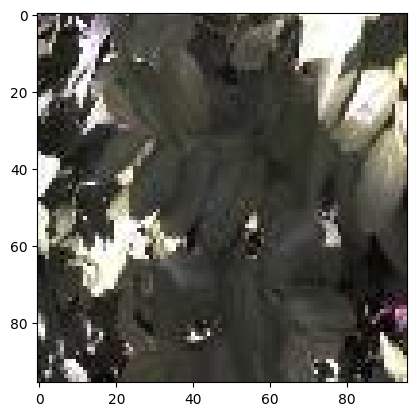

In [ ]:
# Create generators to read images from dataset directory
# -------------------------------------------------------

# Batch size
bs = 8

# img shape, competition dataset does not have regular shapes, must search a method to solve
img_h = 96
img_w = 96

classes = 8

decide_class_indices = True
if decide_class_indices:
    labels = ['Species1', 'Species2', 'Species3','Species4', 'Species5', 'Species6','Species7','Species8']
else:
    labels = None

#training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(img_h, img_w),
                                               batch_size=bs,
                                               classes=labels,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)
# targets are directly converted into one-hot vectors

#for cycle to show training images
from matplotlib import pyplot as plt
%matplotlib inline

n_array_images, n_array_labels = train_gen.next()
print("Training Set")
for images in n_array_images[:4]:
        plt.imshow(images)
        plt.show()



# Validation,
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               target_size=(img_h, img_w),
                                               batch_size=bs, 
                                               classes=labels,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)

#for cycle to show validation images
n_array_images, n_array_labels = valid_gen.next()
print("Validation Set")
for images in n_array_images[:4]:
        plt.imshow(images)
        plt.show()

In [ ]:
# This calculate the weights for all the classes
# by counting the number of images for each class
# and dividing by the number of total images

category_weight = {}
elements_per_class = {}

for i in range(classes):
    category_weight[i] = 0.0

for i in range(classes):
    elements_per_class[i] = 0

_, classes_directories, _ = next(os.walk(training_dir))

for img_class in classes_directories:
    class_dir = training_dir + '/' + str(img_class)
    _, _, files = next(os.walk(class_dir))
    elements_per_class[labels.index(img_class)] = len(files)

total_images = sum(elements_per_class.values())

for i in category_weight.keys():
    category_weight[i] = total_images / (classes * elements_per_class[i])

print(category_weight)
print(elements_per_class)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
{0: 487, 1: 487, 2: 487, 3: 487, 4: 487, 5: 487, 6: 487, 7: 487}


# Dataset Objects

In [ ]:
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, classes]))


# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

In [ ]:
train_gen.class_indices

{'Species1': 0,
 'Species2': 1,
 'Species3': 2,
 'Species4': 3,
 'Species5': 4,
 'Species6': 5,
 'Species7': 6,
 'Species8': 7}

# Transfer Learning

In [ ]:
transfer_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
#transfer_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
#transfer_model = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=None, 
#                                                         input_shape=(img_h, img_w, 3), pooling='max')
#transfer_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_h, img_w, 3), alpha=1.0, 
#                                                                include_top=False, weights='imagenet', 
#                                                                input_tensor=None, pooling=None)
#transfer_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet',
#                                                             input_shape=(img_h, img_w, 3))
#transfer_model = tf.keras.applications.resnet_v2.ResNet101V2(include_top=False, weights='imagenet',
#                                                            input_shape=(img_h, img_w, 3))

#transfer_model = tf.keras.applications.EfficientNetV2M(include_top=False, weights='imagenet',
#                                                       input_shape=(img_h, img_w, 3))
#transfer_model = tf.keras.applications.convnext.ConvNeXtXLarge(weights='imagenet', include_top=False, 
#                                                               input_shape=(img_h, img_w, 3))
#transfer_model = tf.keras.applications.convnext.ConvNeXtBase(weights='imagenet', include_top=False, 
#                                                             input_shape=(img_h, img_w, 3))

In [ ]:
#Layers visualization
transfer_model.summary()
#transfer_model.layers

Model: "convnext_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 convnext_base_prestem_normaliz  (None, 96, 96, 3)   0           ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 24, 24, 128)  6528       ['convnext_base_prestem_normaliza
 )                                                               tion[0][0]']                     
                                                                                      

 mbda)                                                            'convnext_base_stage_0_block_2_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_downsampling_blo  (None, 12, 12, 256)  131584     ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 12, 12, 256)  12800      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 12, 12, 256)  512        ['convnext_base_stage_1_block_0_d
 layernorm

 ck_1 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 6, 6, 512)   25600       ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 6, 6, 512)   1024        ['convnext_base_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 6, 6, 2048)  1050624     ['convnext_base_stage_2_block_0_l
 pointwise_conv_1 (Dense)                                        ayernorm[0][0]']                 
          

                                                                                                  
 convnext_base_stage_2_block_3_  (None, 6, 6, 2048)  1050624     ['convnext_base_stage_2_block_3_l
 pointwise_conv_1 (Dense)                                        ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 6, 6, 2048)  0           ['convnext_base_stage_2_block_3_p
 gelu (Activation)                                               ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 6, 6, 512)   1049088     ['convnext_base_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_

 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 6, 6, 512)   512         ['convnext_base_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 6, 6, 512)   0           ['convnext_base_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 6, 6, 512)   0           ['tf.__operators__.add_11[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_6_i
          

 tf.__operators__.add_15 (TFOpL  (None, 6, 6, 512)   0           ['tf.__operators__.add_14[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_9_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_2_block_10  (None, 6, 6, 512)   25600       ['tf.__operators__.add_15[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_10  (None, 6, 6, 512)   1024        ['convnext_base_stage_2_block_10_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
          

 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_13  (None, 6, 6, 512)   1024        ['convnext_base_stage_2_block_13_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 6, 6, 2048)  1050624     ['convnext_base_stage_2_block_13_
 _pointwise_conv_1 (Dense)                                       layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 6, 6, 2048)  0           ['convnext_base_stage_2_block_13_
 _gelu (Ac

                                                                                                  
 convnext_base_stage_2_block_16  (None, 6, 6, 2048)  1050624     ['convnext_base_stage_2_block_16_
 _pointwise_conv_1 (Dense)                                       layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 6, 6, 2048)  0           ['convnext_base_stage_2_block_16_
 _gelu (Activation)                                              pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_16  (None, 6, 6, 512)   1049088     ['convnext_base_stage_2_block_16_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_

 _gelu (Activation)                                              pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 6, 6, 512)   1049088     ['convnext_base_stage_2_block_19_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_19  (None, 6, 6, 512)   512         ['convnext_base_stage_2_block_19_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 6, 6, 512)   0           ['convnext_base_stage_2_block_19_
 _identity (Activation)                                          layer_scale[0][0]']              
          

 convnext_base_stage_2_block_22  (None, 6, 6, 512)   512         ['convnext_base_stage_2_block_22_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_22  (None, 6, 6, 512)   0           ['convnext_base_stage_2_block_22_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_28 (TFOpL  (None, 6, 6, 512)   0           ['tf.__operators__.add_27[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_22_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_

                                                                                                  
 tf.__operators__.add_31 (TFOpL  (None, 6, 6, 512)   0           ['tf.__operators__.add_30[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_25_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_26  (None, 6, 6, 512)   25600       ['tf.__operators__.add_31[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_26  (None, 6, 6, 512)   1024        ['convnext_base_stage_2_block_26_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )        

                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 3, 3, 1024)  51200       ['tf.__operators__.add_34[0][0]']
 depthwise_conv (Conv2D)                                                                          
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 3, 3, 1024)  2048        ['convnext_base_stage_3_block_2_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 3, 3, 4096)  4198400     ['convnext_base_stage_3_block_2_l
 pointwise_conv_1 (Dense)                                        ayernorm[0][0]']                 
          

# First training

In [ ]:
transfer_model.trainable = False 

model = tf.keras.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5, noise_shape=None, seed=SEED))
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=classes, activation='softmax'))

# Visualize created model as a table
model.summary()



```
#attempting in changing the top of the network

transfer_model.trainable = False 

model = tf.keras.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024,
                                activation='relu',
                                kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.2, stddev=0.05, seed=None)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=classes,
                                activation='softmax',
                                kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.2, stddev=0.05, seed=None)))

# Visualize created model as a table
model.summary()
```





```
#attempting in changing the top of the network

transfer_model.trainable = False 

model = tf.keras.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3, noise_shape=None, seed=SEED))
model.add(tf.keras.layers.Dense(units=classes, activation='softmax'))

# Visualize created model as a table
model.summary()
```



# Optimization params transfer learning

In [ ]:
# Loss
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Optimizer

optimizer_tl = tf.keras.optimizers.Adam(learning_rate=4e-3,
                                        beta_1=0.9,
                                        beta_2=0.999                                                     
                                        )

# Validation metrics
metrics = ['accuracy']

# Compile Model
model.compile(optimizer=optimizer_tl, loss=loss, metrics=metrics)

# Experiments Directory Creation

In [ ]:
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'vgg16_model'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

# Training

In [ ]:
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_class_{epoch:02d}.ckpt'),
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                   mode='max',
                                                   patience=10)
    callbacks.append(es_callback)
    
# Weight decay
# ------------

wd_callback = tf.keras.callbacks.ReduceLROnPlateau("val_loss", 0.05, patience=10)
callbacks.append(wd_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          class_weight = category_weight,
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir classification_experiments --port 6066     <- from terminal
# 2. localhost:6066   <- in your browser

# Fine Tuning

In [ ]:
# Set all vgg16 layers to True
model.get_layer('vgg16').trainable = True
for i, layer in enumerate(model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
freeze_until = 5 # layer from which we want to fine-tune

# Freeze the until freeze_until
for i, layer in enumerate(model.get_layer('vgg16').layers[:freeze_until]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
model.summary()

# Visualize created model as a table
model.summary()

# Optimization params fine tuning

In [ ]:
# Loss
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Optimizer

optimizer_tl = tf.keras.optimizers.Adam(learning_rate=5e-5,
                                        beta_1=0.9,
                                        beta_2=0.999                                                     
                                        )

# Validation metrics
metrics = ['accuracy']

# Compile Model
model.compile(optimizer=optimizer_tl, loss=loss, metrics=metrics)

# Re training

In [ ]:
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'vgg16_model'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

In [ ]:
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_fine_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                   mode='max',
                                                   patience=10)
    callbacks.append(es_callback)

# Weight decay
# ------------

wd_callback = tf.keras.callbacks.ReduceLROnPlateau("val_loss", 0.05, patience=10)
callbacks.append(wd_callback)


model.fit(x=train_dataset,
          epochs=30,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          class_weight = category_weight,
          callbacks=callbacks)

In [ ]:
# Save the model
# Save best epoch model
model.save('vgg16_model')

In [ ]:
del model